In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report , roc_auc_score, auc, roc_curve
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt

## **資料來源**
* 美國癌症登記資料庫(Surveillance, Epidemiology, and End Results Program, SEER)，自西元1973至2014年間的呼吸道相關癌症病例。本研究採用的資料範圍為2004年至2014年之非小細胞肺癌資料。
* 包含以下四個資料集，追蹤截止日期為2016年12月31日:
    * yr1973_2014.seer9  
    包含自1973年至2014年，亞特蘭大、康乃狄克州、底特律、夏威夷州、愛荷華州、新墨西哥州、奧克蘭、西雅圖-普吉特海灣與猶他州以上九個SEER登記處的資料。
    * yr1992_2014.sj_la_rg_ak  
    包含自1992年至2014年，蒙特雷、洛杉磯、喬治亞州與阿拉斯加原住民SEER登記處的資料。
    * yr2000_2014.ca_ky_lo_nj_gaS  
    包含自2000年至2014年，加利福尼亞州、肯塔基州、路易斯安那州、紐澤西州與喬治亞州SEER登記處的資料。
    * yr2005.lo_2nd_half  
    包含自2005年7月至12月路易斯安那州的診斷資料，因Katrina颱風在這六個月的期間對路易斯安那州的人口產生了很大的影響，大多數的SEER報告未分析在這六個月間路易斯安那州的診斷資料，因此將此資料集在本研究中排除。
* 資料範圍:  
    本研究採用前三個資料集 yr1973_2014.seer9、yr1992_2014.sj_la_rg_ak、yr2000_2014.ca_ky_lo_nj_ga 呼吸道相關癌症病例中的非小細胞肺癌資料。

## **資料合併與年份篩選**
* 許多欄位適用於2004(含)年以後的資料，因此本研究採用診斷年份介於2004年至2014之數據，共606615筆資料
* 採用資料範圍:  
    SEER資料庫提供的2004年至2014年的非小細胞肺癌資料。將本研究採用的三個資料集 yr1973_2014.seer9、r1992_2014.sj_la_rg_ak、yr2000_2014.ca_ky_lo_nj_ga 合併，並且篩選出2004年至2014年的資料

In [2]:
data = []
path = ['data/yr1973_2014.seer9/RESPIR.TXT', 'data/yr1992_2014.sj_la_rg_ak/RESPIR.TXT', 'data/yr2000_2014.ca_ky_lo_nj_ga/RESPIR.TXT']

def load_data(path):
    """Load datasets and filter out entries with 'Year of diagnosis' < 2004"""
    with open(path) as f:
        for line in f:
            if int(line[38:42]) < 2004:
                continue
            else:
                data.append(line.rstrip())
for p in path:
    load_data(p)

每筆資料由一串數字與空白鍵組成，如下:

In [3]:
data[0]

'070000490000001502201 020821923   02032006C34118041380413311        9796                       99921060000999               98820300053771  0102000205500205200000   1         01             217     220301623C341      1161003 01980631104        009009    220302203040735999910019947                   00001                                   99     8          0200'

## **欄位分割**
* 依說明文件將資料依position作欄位切割，共133個欄位
* 將資料轉成dataframe
* 空白字串為missing value，以NAN取代
* shape of dataframe: (606615, 133)

In [4]:
cutpoint = [(1, 8), (9, 18), (19, 19), (20, 21), (23, 23), (24, 24), (25, 27), (28, 31), (35, 36), (37, 38), (39, 42), (43, 46), (47, 47),
            (48, 51), (52, 52), (53, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 63), (64, 65), (66, 67), (68, 68), (69, 70), (71, 72),
            (73, 85), (86, 87), (88, 91), (92, 92), (93, 93), (94, 94), (95, 95), (96, 98), (99, 101), (102, 104), (105, 106), (107, 109),
            (110, 112), (113, 115), (116, 118), (119, 121), (122, 124), (125, 127), (128, 129), (130, 131), (132, 133), (134, 135), (136, 136),
            (137, 137), (138, 138), (141, 146), (147, 152), (153, 158), (159, 160), (161, 161), (162, 162), (163, 164), (166, 166), (170, 171),
            (174, 174), (175, 175), (176, 177), (191, 191), (192, 193), (199, 203), (204, 207), (208, 211), (218, 220), (221, 223), (224, 224),
            (226, 227), (228, 229), (230, 232), (233, 233), (234, 234), (235, 235), (236, 236), (237, 238), (239, 240), (241, 241), (242, 242),
            (245, 245), (246, 250), (255, 259), (260, 264), (265, 265), (266, 266), (267, 267), (268, 269), (270, 271), (272, 272), (273, 273),
            (274, 274), (275, 275), (276, 276), (277, 277), (278, 278), (279, 279), (280, 281), (282, 284), (285, 287), (288, 290), (291, 293),
            (294, 296), (297, 299), (300, 300), (301, 304), (305, 305), (311, 311), (312, 314), (315, 317), (318, 320), (321, 323), (324, 325),
            (326, 327), (328, 329), (330, 331), (332, 334), (335, 337), (338, 340), (341, 341), (342, 342), (348, 348), (349, 349), (350, 350),
            (351, 351), (352, 352), (353, 353), (355, 355), (357, 357), (359, 360), (361, 362)]

In [5]:
labels=['Patient ID number', 'Registry ID', 'Marital Status at DX', 'Race/Ethnicity', 'NHIA Derived Hispanic Origin', 'Sex', 'Age at diagnosis',
        'Year of Birth', 'Sequence Number—Central', 'Month of diagnosis', 'Year of diagnosis', 'Primary Site', 'Laterality',
        'Histology (92-00) ICD-O-2', 'Behavior (92-00) ICD-O-2', 'Histologic Type ICD-O-3', 'Behavior Code ICD-O-3', 'Grade',
        'Diagnostic Confirmation', 'Type of Reporting Source', 'EOD—Tumor Size', 'EOD—Extension', 'EOD—Extension Prost Path',
        'EOD—Lymph Node Involv', 'Regional Nodes Positive', 'Regional Nodes Examined', 'EOD—Old 13 Digit', 'EOD—Old 2 Digit',
        'EOD—Old 4 Digit', 'Coding System for EOD', 'Tumor Marker 1', 'Tumor Marker 2', 'Tumor Marker 3', 'CS Tumor Size', 'CS Extension',
        'CS Lymph Nodes', 'CS Mets at Dx', 'CS Site-Specific Factor 1', 'CS Site-Specific Factor 2', 'CS Site-Specific Factor 3',
        'CS Site-Specific Factor 4', 'CS Site-Specific Factor 5', 'CS Site-Specific Factor 6', 'CS Site-Specific Factor 25', 'Derived AJCC T',
        'Derived AJCC N', 'Derived AJCC M', 'Derived AJCC Stage Group', 'Derived SS1977', 'Derived SS2000', 'Derived AJCC—Flag',
        'CS Version Input Original', 'CS Version Derived', 'CS Version Input Current', 'RX Summ—Surg Prim Site', 'RX Summ—Scope Reg LN Sur',
        'RX Summ—Surg Oth Reg/Dis', 'RX Summ—Reg LN Examined', 'Reason for no surgery', 'RX Summ—Surgery Type', 'RX Summ—Scope Reg 98-02',
        'RX Summ—Surg Oth 98-02', 'SEER Record Number', 'SEER Type of Follow-up', 'Age Recode <1 Year olds', 'Site Recode ICD-O-3/WHO 2008',
        'Recode ICD-O-2 to 9', 'Recode ICD-O-2 to 10', 'ICCC site recode ICD-O-3/WHO 2008', 'ICCC site rec extended ICD-O-3/WHO 2008',
        'Behavior Recode for Analysis', 'Histology Recode—Broad Groupings', 'Histology Recode—Brain Groupings', 'CS Schema v0204+',
        'Race recode (White, Black, Other)', 'Race recode (W, B, AI, API)', 'Origin recode NHIA (Hispanic, NonHisp)', 'SEER historic stage A',
        'AJCC stage 3rd edition (1988-2003)', 'SEER modified AJCC Stage 3rd ed (1988-2003)',  'SEER Summary Stage 1977 (1995-2000)',
        'SEER Summary Stage 2000 (2001-2003) ', 'First malignant primary indicator', 'State-county recode', 'Cause of Death to SEER site recode',
        'COD to site rec KM', 'Vital Status recode', 'IHS Link', 'Summary stage 2000 (1998+)', 'AYA site recode/WHO 2008',
        'Lymphoma subtype recode/WHO 2008', 'SEER Cause-Specific Death Classification', 'SEER Other Cause of Death Classification',
        'CS Tumor Size/Ext Eval', 'CS Lymph Nodes Eval', 'CS Mets Eval', 'Primary by international rules', 'ER Status Recode Breast Cancer (1990+)',
        'PR Status Recode Breast Cancer (1990+)', 'CS Schema -AJCC 6th ed (previously called v1)', 'CS Site-Specific Factor 8',
        'CS Site-Specific Factor 10', 'CS Site-Specific Factor 11', 'CS Site-Specific Factor 13', 'CS Site-Specific Factor 15',
        'CS Site-Specific Factor 16', 'Lymph vascular invasion', 'Survival months', 'Survival months flag', 'Insurance recode (2007+)', 'Derived AJCC-7 T',
        'Derived AJCC-7 N', 'Derived AJCC-7 M', 'Derived AJCC-7 Stage Grp', 'Breast Adjusted AJCC 6th T (1988+)', 'Breast Adjusted AJCC 6th N (1988+)',
        'Breast Adjusted AJCC 6th M (1988+)', 'Breast Adjusted AJCC 6th Stage (1988+)', 'CS Site-Specific Factor 7', 'CS Site-Specific Factor 9',
        'CS Site-Specific Factor 12', 'Derived HER2 Recode (2010+)', 'Breast Subtype (2010+)', 'Lymphomas: Ann Arbor Staging (1983+)',
        'CS Mets at Dx-Bone', 'CS Mets at Dx-Brain', 'CS Mets at Dx-Liver', 'CS Mets at Dx-Lung', 'T value - based on AJCC 3rd (1988-2003)',
        'N value - based on AJCC 3rd (1988-2003)', 'M value - based on AJCC 3rd (1988-2003)', 'Total Number of In Situ/malignant Tumors for Patient',
        'Total Number of Benign/Borderline Tumors for Patient']

In [6]:
def split(entry):
    return [entry[i-1:j] for i, j in cutpoint]

splited_data = list(map(split, data))
df = pd.DataFrame(splited_data, columns = labels)

In [7]:
df.head()

,Patient ID number,Registry ID,Marital Status at DX,Race/Ethnicity,NHIA Derived Hispanic Origin,Sex,Age at diagnosis,Year of Birth,Sequence Number—Central,Month of diagnosis,...,Lymphomas: Ann Arbor Staging (1983+),CS Mets at Dx-Bone,CS Mets at Dx-Brain,CS Mets at Dx-Liver,CS Mets at Dx-Lung,T value - based on AJCC 3rd (1988-2003),N value - based on AJCC 3rd (1988-2003),M value - based on AJCC 3rd (1988-2003),Total Number of In Situ/malignant Tumors for Patient,Total Number of Benign/Borderline Tumors for Patient
0,07000049,0000001502,2,01,0,2,082,1923,02,03,...,8,,,,,,,,02,00
1,07000061,0000001502,5,01,0,1,083,1925,02,08,...,8,,,,,,,,02,00
2,07000175,0000001502,2,01,0,1,085,1921,03,09,...,8,,,,,,,,03,00
3,07000291,0000001502,5,01,0,2,084,1929,02,08,...,8,1,0,0,0,,,,02,00
4,07000428,0000001502,2,01,0,1,077,1931,04,12,...,8,,,,,,,,04,00


In [8]:
# Replace values that is entirely spaces with NAN.
# Convert dataset to integer.
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.apply(pd.to_numeric, downcast='integer', errors='ignore')
df.head()

,Patient ID number,Registry ID,Marital Status at DX,Race/Ethnicity,NHIA Derived Hispanic Origin,Sex,Age at diagnosis,Year of Birth,Sequence Number—Central,Month of diagnosis,...,Lymphomas: Ann Arbor Staging (1983+),CS Mets at Dx-Bone,CS Mets at Dx-Brain,CS Mets at Dx-Liver,CS Mets at Dx-Lung,T value - based on AJCC 3rd (1988-2003),N value - based on AJCC 3rd (1988-2003),M value - based on AJCC 3rd (1988-2003),Total Number of In Situ/malignant Tumors for Patient,Total Number of Benign/Borderline Tumors for Patient
0,7000049,1502,2,1,0,2,82,1923.0,2,3,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
1,7000061,1502,5,1,0,1,83,1925.0,2,8,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
2,7000175,1502,2,1,0,1,85,1921.0,3,9,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
3,7000291,1502,5,1,0,2,84,1929.0,2,8,...,8,1.0,0.0,0.0,0.0,NaN,NaN,NaN,2,0
4,7000428,1502,2,1,0,1,77,1931.0,4,12,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0


In [9]:
def df_info(df):
    '''Show shape, info, percentage of missing values in each column.'''
    
    print(f'Shape of data: {df.shape}\n')
    print('Info of data:')
    print(df.info())
    
    nan_num = df.isnull().sum()
    nan_df = pd.concat([nan_num, nan_num / df.shape[0]], axis = 1, keys = ['Num of NAN', '% of NAN'])
    nan_df = nan_df.loc[nan_df['Num of NAN'] > 0].sort_values(by = ['Num of NAN'], ascending = False)
    print(f'\nThere are {nan_df.shape[0]} columns have missing valus:')
    if not nan_df.empty:
        print(nan_df)
    
df_info(df)

Shape of data: (606615, 133)

Info of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606615 entries, 0 to 606614
Columns: 133 entries, Patient ID number to Total Number of Benign/Borderline Tumors for Patient
dtypes: float64(58), int16(18), int32(4), int8(51), object(2)
memory usage: 337.3+ MB
None

There are 58 columns have missing valus:
                                             Num of NAN  % of NAN
M value - based on AJCC 3rd (1988-2003)          606615  1.000000
CS Site-Specific Factor 15                       606615  1.000000
SEER modified AJCC Stage 3rd ed (1988-2003)      606615  1.000000
SEER Summary Stage 1977 (1995-2000)              606615  1.000000
T value - based on AJCC 3rd (1988-2003)          606615  1.000000
EOD—Tumor Size                                   606615  1.000000
CS Site-Specific Factor 8                        606615  1.000000
CS Site-Specific Factor 10                       606615  1.000000
CS Site-Specific Factor 11                       606615

## Primary Site(原發部位) & Histology(組織類型)
選取非小細胞肺癌範圍的資料:
* 選取依國際腫瘤(學)科疾病分類第三版(ICD-O-3)定義Primary site為肺部(編碼: C340-C343, C348, C349)的資料，共562878筆
* 依組織類型(Histologic Type ICD-O-3)篩選出非小細胞肺癌(NSCLC)的資料，共452033筆
* 欄位Histologic Type ICD-O-3共有101種category。取前四高的category(占82%)，其餘的合併成others

In [10]:
# Select data whose primary site is lung
primary_site = ['C340','C341','C342','C343','C348','C349']
df = df.loc[df['Primary Site'].isin(primary_site)]
df.shape

(562878, 133)

In [11]:
# Select NSCLC data
histology = [*range(8010, 8015 + 1), *range(8020, 8022 + 1), *range(8030, 8040 + 1),
             8046, *range(8050, 8052 + 1), *range(8070, 8084 + 1), *range(8090, 8110 + 1),
             *range(8120, 8131 + 1), *range(8140, 8156 + 1), *range(8160, 8162 + 1),
             *range(8170, 8175 + 1), 8180, *range(8190, 8221 + 1), *range(8230, 8231 + 1),
             *range(8240, 8263 + 1), *range(8270, 8280 + 1), *range(8290, 8337 + 1),
             *range(8340, 8347 + 1), *range(8350, 8390 + 1), *range(8400, 8562 + 1),
             *range(8570, 8576 + 1), *range(8580, 8671 + 1), *range(8940, 8941 + 1)]
df = df.loc[df['Histologic Type ICD-O-3'].isin(histology)]
df.shape

(452033, 133)

In [12]:
print(f'feature Histologic Type ICD-O-3 has {df["Histologic Type ICD-O-3"].nunique()} categories\n')
print(df['Histologic Type ICD-O-3'].value_counts())

feature Histologic Type ICD-O-3 has 101 categories

8140    176277
8070     99959
8046     64390
8010     31996
8250     10690
         ...  
8342         1
8262         1
8503         1
8585         1
8340         1
Name: Histologic Type ICD-O-3, Length: 101, dtype: int64


In [13]:
sum(df['Histologic Type ICD-O-3'].value_counts()[:4])/df.shape[0]

0.8243247727488923

In [14]:
df.loc[~df['Histologic Type ICD-O-3'].isin(df['Histologic Type ICD-O-3'].value_counts()[:4].index), 'Histologic Type ICD-O-3'] = 'others'

## Survival months & Cause of death
* Target為存活狀態(存活/死亡)，由survival months衍生而來。  
以一年後存活狀態為例，survival months >= 12者視為存活(code = 1)，survival months < 12者視為死亡(code = 0)
* 刪除survival months = 9999的資料。  
9999代表unkown，為判別在一定時間後結果是存活/死亡，故將其刪除。
* 排除死亡原因為癌症以外的資料
* shape of dataframe: (415655, 132)

In [15]:
# Remove data whose survival months is unknown
df = df.loc[df['Survival months'] != 9999]

In [16]:
# Remove data whose cause of death is something other than cancer
df = df.loc[df['SEER Other Cause of Death Classification'] != 1]
df = df.drop(['SEER Other Cause of Death Classification'], axis=1)
df.shape

(415655, 132)

## **欄位篩選**
SEER提供的133個欄位，大致可以分為以下幾類:
* 人口學欄位(如性別、年齡)
* 診斷欄位(如腫瘤部位、分級、腫瘤大小)
* 治療欄位(如手術方式)
* 結果欄位(如存活月數、死亡原因)
* 重新編碼後另造的欄位

欄位篩選過程如下:
1. 刪除全為空值的欄位
2. 刪除只有一種值的欄位
3. 刪除不適用於 2004 至 2014 年的欄位
4. 刪除可能表明患者存活狀態的欄位
5. 刪除重覆性、重新編碼的欄位
6. 刪除類別種類太多的欄位 

篩選後剩29個欄位

In [17]:
# Drop columns with all nan values
print(f'Columns with all nan values: \n{df.columns[df.isna().all()]}')
df = df.dropna(how='all', axis=1)

Columns with all nan values: 
Index(['EOD—Tumor Size', 'EOD—Extension', 'EOD—Extension Prost Path',
       'EOD—Lymph Node Involv', 'EOD—Old 13 Digit', 'EOD—Old 2 Digit',
       'EOD—Old 4 Digit', 'Coding System for EOD', 'Tumor Marker 1',
       'Tumor Marker 2', 'Tumor Marker 3', 'CS Site-Specific Factor 3',
       'CS Site-Specific Factor 4', 'CS Site-Specific Factor 5',
       'CS Site-Specific Factor 6', 'RX Summ—Reg LN Examined',
       'RX Summ—Surgery Type', 'RX Summ—Scope Reg 98-02',
       'RX Summ—Surg Oth 98-02', 'AJCC stage 3rd edition (1988-2003)',
       'SEER modified AJCC Stage 3rd ed (1988-2003)',
       'SEER Summary Stage 1977 (1995-2000)',
       'SEER Summary Stage 2000 (2001-2003) ', 'CS Site-Specific Factor 8',
       'CS Site-Specific Factor 10', 'CS Site-Specific Factor 11',
       'CS Site-Specific Factor 13', 'CS Site-Specific Factor 15',
       'CS Site-Specific Factor 16', 'Lymph vascular invasion',
       'Breast Adjusted AJCC 6th T (1988+)',
       'Brea

In [18]:
# Drop columns with only one distinct value(constant column)
drop_list = list(df.loc[:, df.apply(pd.Series.nunique) == 1].columns)
print(f'Columns with only one distinct value:\n {drop_list}')
df = df.drop(drop_list, axis = 1)

Columns with only one distinct value:
 ['CS Site-Specific Factor 25', 'Derived AJCC—Flag', 'CS Version Derived', 'SEER Type of Follow-up', 'Site Recode ICD-O-3/WHO 2008', 'Histology Recode—Brain Groupings', 'CS Schema v0204+', 'Lymphoma subtype recode/WHO 2008', 'ER Status Recode Breast Cancer (1990+)', 'PR Status Recode Breast Cancer (1990+)', 'CS Schema -AJCC 6th ed (previously called v1)', 'Derived HER2 Recode (2010+)', 'Breast Subtype (2010+)', 'Lymphomas: Ann Arbor Staging (1983+)']


In [19]:
# Remove columns that are not applicable between 2004-2014
drop_list = ['Race/Ethnicity', 'Derived AJCC-7 T', 'Derived AJCC-7 N', 'Derived AJCC-7 M',
             'Derived AJCC-7 Stage Grp','CS Site-Specific Factor 2', 'CS Mets at Dx-Bone',
             'CS Mets at Dx-Brain', 'CS Mets at Dx-Liver', 'CS Mets at Dx-Lung']
df = df.drop(drop_list, axis = 1)

# Remove columns that directly or indirectly specify the outcome(alive/dead)
drop_list = ['Type of Reporting Source', 'Vital Status recode',
             'COD to site rec KM', 'Cause of Death to SEER site recode',
             'SEER Cause-Specific Death Classification', 'RX Summ—Surg Oth Reg/Dis']
df = df.drop(drop_list, axis = 1)

# Remove Recode columns
drop_list = ['ICCC site recode ICD-O-3/WHO 2008', 'ICCC site rec extended ICD-O-3/WHO 2008',
             'AYA site recode/WHO 2008', 'CS Version Input Original', 'CS Version Input Current',
             'CS Tumor Size/Ext Eval', 'CS Lymph Nodes Eval', 'CS Mets Eval',
             'Recode ICD-O-2 to 9', 'Recode ICD-O-2 to 10', 'Age Recode <1 Year olds',
             'Insurance recode (2007+)', 'Histology (92-00) ICD-O-2', 'Behavior (92-00) ICD-O-2',
             'Survival months flag', 'Summary stage 2000 (1998+)',
             'SEER historic stage A', 'IHS Link', 'Derived SS1977', 'Derived SS2000',
             'Behavior Recode for Analysis', 'Race recode (White, Black, Other)',
             'NHIA Derived Hispanic Origin', 'Histology Recode—Broad Groupings',
             'Total Number of In Situ/malignant Tumors for Patient',
             'Total Number of Benign/Borderline Tumors for Patient']
df = df.drop(drop_list, axis = 1)

# Remove columns that vary too much
drop_list = ['State-county recode']
df = df.drop(drop_list, axis = 1)

# Remove others, irrelevant columns
drop_list = ['Patient ID number', 'Registry ID', 'Year of Birth', 'Month of diagnosis', 
             'SEER Record Number', 'Primary by international rules']
df = df.drop(drop_list, axis = 1)

In [20]:
def cat_percent_plot(feature, data):
    '''Plot countplot with percentage of each category.'''
    total = data.shape[0]
    ax = sns.countplot(x=feature, data=data)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x()
        y = p.get_height() + 0.02
        ax.annotate(percentage, (x, y), size = 10)
    plt.show()

## **欄位描述**

 |Feature                                              |Description                                     |Type      
---|-----------------------------------------------------|------------------------------------------------|----------
1|Marital Status at DX                                 |診斷時婚姻狀態                                   |Catogorical
2|Sex                                                  |性別                                            |Catogorical
3|Age at diagnosis                                     |診斷年齡                                         |Numerical
4|Sequence Number—Central                              |癌症發生順序號碼，個案一生中所罹患惡性腫瘤的發生順序 |Numerical
5|Year of diagnosis                                    |診斷年份                                         |Numerical
6|Primary Site                                         |原發部位                                         |Categorical
7|Laterality                                           |側性                                             |Categorical
8|Histologic Type ICD-O-3                              |組織形態，原發腫瘤細胞於顯微鏡下之結構              |Categorical
9|Behavior Code ICD-O-3                                |性態碼                                            |Categorical
10|Grade                                                |分級                                             |Categorical
11|Diagnostic Confirmation                              |癌症確診方式                                      |Categorical
12|Regional Nodes Positive                              |區域淋巴結侵犯數目                                 |Numerical
13|Regional Nodes Examined                              |區域淋巴結檢查數目                                 |Numerical
14|CS Tumor Size                                        |腫瘤大小                                          |Numerical
15|CS Extension                                         |腫瘤擴散程度                                      |Categorical
16|CS Lymph Nodes                                       |淋巴結侵犯狀態                                    |Categorical
17|CS Mets at Dx                                        |診斷時遠端轉移                                    |Categorical
18|CS Site-Specific Factor 1                            |癌症部位特定因子1                                 |Categorical
19|Derived AJCC T                                       |腫瘤分期 T                                        |Categorical
20|Derived AJCC N                                       |腫瘤分期 N                                        |Categorical
21|Derived AJCC M                                       |腫瘤分期 M                                        |Categorical
22|Derived AJCC Stage Group                             |腫瘤分期                                          |Categorical
23|RX Summ—Surg Prim Site                               |原發部位手術方式                                   |Categorical
24|RX Summ—Scope Reg LN Sur                             |區域淋巴結手術範圍                                 |Categorical
25|Reason for no surgery                                |發部位未手術原因                                   |Categorical
26|Race recode (W, B, AI, API)                          |種族                                              |Categorical
27|Origin recode NHIA (Hispanic, NonHisp)               |是否為西班牙裔                                     |Categorical
28|First malignant primary indicator                    |第一個惡性腫流主要指標                              |Categorical
29|Survival months                                      |存活月數                                          |Numerical

In [21]:
df_info(df)

Shape of data: (415655, 29)

Info of data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 415655 entries, 1 to 606614
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Marital Status at DX                    415655 non-null  int8   
 1   Sex                                     415655 non-null  int8   
 2   Age at diagnosis                        415655 non-null  int16  
 3   Sequence Number—Central                 415655 non-null  int8   
 4   Year of diagnosis                       415655 non-null  int16  
 5   Primary Site                            415655 non-null  object 
 6   Laterality                              415655 non-null  int8   
 7   Histologic Type ICD-O-3                 415655 non-null  object 
 8   Behavior Code ICD-O-3                   415655 non-null  int8   
 9   Grade                                   415655 non-null  int8   
 10  D

In [22]:
numerical_col = ['Age at diagnosis', 'Sequence Number—Central', 'Year of diagnosis',
               'Regional Nodes Positive', 'Regional Nodes Examined', 'CS Tumor Size', 'Survival months']
df[numerical_col].describe()

,Age at diagnosis,Sequence Number—Central,Year of diagnosis,Regional Nodes Positive,Regional Nodes Examined,CS Tumor Size,Survival months
count,415655.000000,415655.000000,415655.000000,415655.000000,415655.000000,415655.000000,415655.000000
mean,69.146978,0.659114,2009.107156,73.131794,11.283889,259.023394,19.287577
std,11.583472,1.137260,3.156697,42.334304,28.362947,402.101300,25.990341
min,2.000000,0.000000,2004.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,0.000000,2006.000000,6.000000,0.000000,25.000000,2.000000
50%,70.000000,0.000000,2009.000000,98.000000,0.000000,45.000000,9.000000
75%,77.000000,2.000000,2012.000000,98.000000,4.000000,100.000000,25.000000
max,999.000000,99.000000,2014.000000,99.000000,99.000000,999.000000,131.000000


## 資料分割
* 選取診斷年份2004~2009的資料。  
本研究對非小細胞肺癌患者第五年存活情形進行預測，而自診斷時間至追蹤截止時間止之觀察時間少於五年者，因無法判斷其存活狀態為何，故將其自分析資料中排除。
* 依Survival months欄位衍生出Target欄位(Survival)  
Survival months >= 60為存活(1)；Survival months < 60為死亡(0)
* 83.39%的資料為死亡，Survival的class分佈不平衡
* 將資料切割成70%訓練集與30%測試集，並維持class的分佈

In [23]:
df = df.loc[df['Year of diagnosis'] <= 2009]
df['Survival'] = (df['Survival months'] >= 60).astype(int)
df = df.drop(['Survival months'], axis = 1)

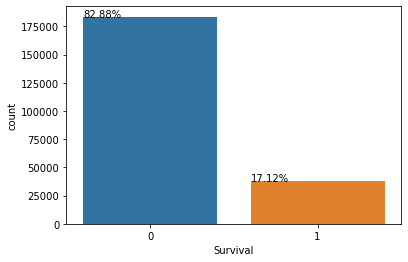

In [24]:
cat_percent_plot('Survival', df)

In [25]:
train, test = train_test_split(df, test_size=0.3, stratify=df['Survival'], random_state=1)
train = train.copy()
test = test.copy()
combine = [train, test]

## Marital Status at DX(診斷時婚姻狀態)
* 取前三個最多的category(總共約占84%): Married, Widowed, Single，其餘的併入others
* 已婚的患者有較高的生存率
* 欄位描述  
1 Single (never married)  
2 Married (including common law)  
3 Separated  
4 Divorced  
5 Widowed  
6 Unmarried or domestic partner (same sex or opposite sex or unregistered)  
9 Unknown  

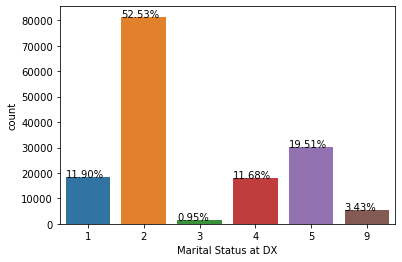

In [26]:
cat_percent_plot('Marital Status at DX', train)

In [27]:
marriage = train['Marital Status at DX'].value_counts()[:3].index
for dataset in combine:
    dataset.loc[~dataset['Marital Status at DX'].isin(marriage), 'Marital Status at DX'] = 'others'
    dataset['Marital Status at DX'] = dataset['Marital Status at DX'].map({1: 'Single(never married)', 2: 'Married', 5: 'Widowed', 'others': 'others'})

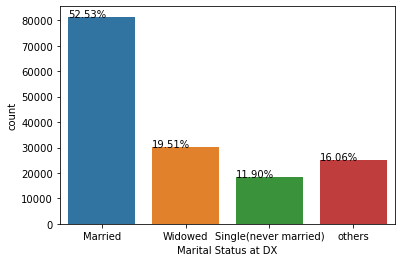

In [28]:
cat_percent_plot('Marital Status at DX', train)

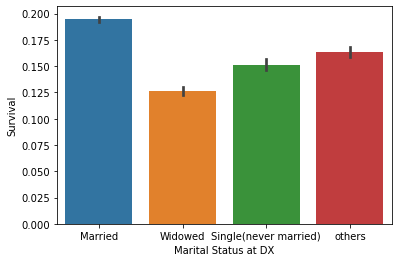

In [29]:
sns.barplot(x='Marital Status at DX', y='Survival', data=train)

## Sex(性別)
* 將每個值減1轉成binary。0(Male), 1(Female)
* 53.78%的資料為男性
* 女性的生存率較男性高
* 欄位描述  
1 Male；2 Female

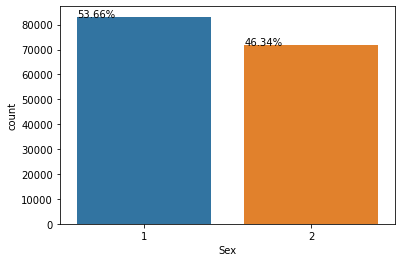

In [30]:
cat_percent_plot('Sex', train)

In [31]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'] - 1

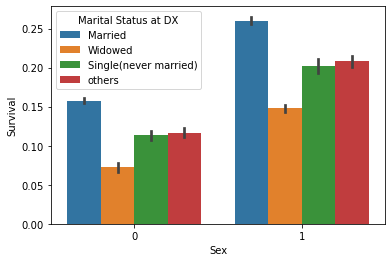

In [32]:
sns.barplot(x='Sex', y='Survival', hue='Marital Status at DX', data=train)

## Age at diagnosis
* 有少數資料為Unknown age(999)，以平均值取代
* 大部分個案年齡為60~80歲
* 20歲以下個案有較高生存率

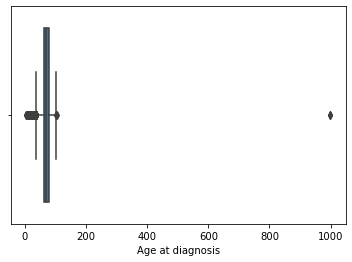

In [33]:
sns.boxplot(train['Age at diagnosis'])

In [34]:
age_mean = train.loc[train['Age at diagnosis'] != 999, 'Age at diagnosis'].mean().round(0).astype(int)
for dataset in combine:
    dataset.loc[dataset['Age at diagnosis'] == 999, 'Age at diagnosis'] = age_mean

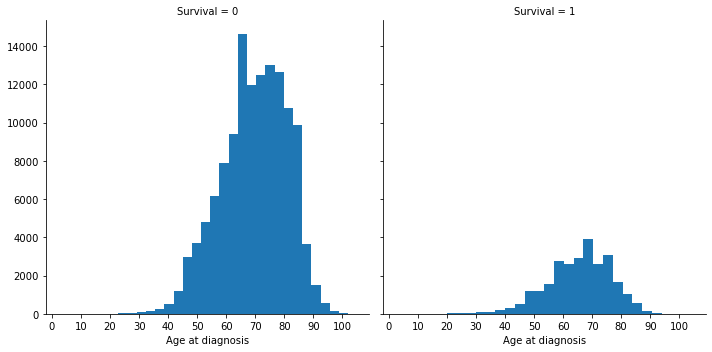

In [35]:
g = sns.FacetGrid(train, col='Survival', height=5)
g.map(plt.hist, 'Age at diagnosis', bins=30)
g.set(xticks=range(0, 110, 10))

## Sequence Number—Central(癌症發生順序號碼)
* 將unknown以mode取代
* 欄位描述  
描述個案一生中發生的所有惡性、原位、良性和邊際性原發性腫瘤的數量和順序。  
0: One primary only in the patient’s lifetime  
1: First of two or more primaries  
2: Second of two or more primaries  
...: (Actual number of this primary)  
99: Unspecified or unknown sequence number

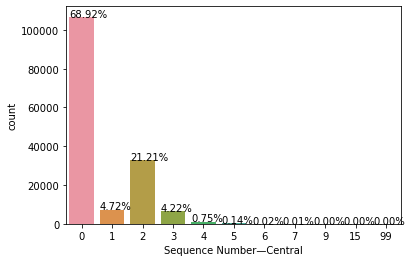

In [36]:
cat_percent_plot('Sequence Number—Central', train)

In [37]:
sequence_mode = train['Sequence Number—Central'].mode()[0]
for dataset in combine: 
    dataset.loc[dataset['Sequence Number—Central'] == 0, 'Sequence Number—Central'] = 1
    dataset.loc[dataset['Sequence Number—Central'] == 99, 'Sequence Number—Central'] = sequence_mode

## Laterality(側性)
* code = 3, 9的側性不清楚，以mode取代
* code = 0, 4資料量極少，併入others
* 欄位描述  
0: 不是成對器官  
1: 原發起源位在右側  
2: 原發起源位在左側  
3: 只有單側侵犯，但起源於左側或右側則不清楚  
4: 雙側侵犯但起源之側位不清楚，且病歷描述是單一原發  
5: 成對器官，位於身體中線的腫瘤  
9: 成對器官，但其側位不清楚

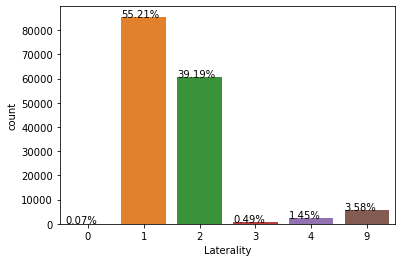

In [38]:
cat_percent_plot('Laterality', train)

In [39]:
laterality_mode = train['Laterality'].mode()[0]
for dataset in combine:
    dataset.loc[dataset['Laterality'].isin([3, 9]), 'Laterality'] = laterality_mode
    dataset.loc[dataset['Laterality'].isin([0, 4]), 'Laterality'] = 'others'
    dataset['Laterality'] = dataset['Laterality'].map({1: 'Right', 2: 'Left', 'others': 'others'})

## Behavior Code ICD-O-3(性態碼)
* 99.93%為惡性(code = 3)
* 將此欄位刪除，因為幾乎為constant feature

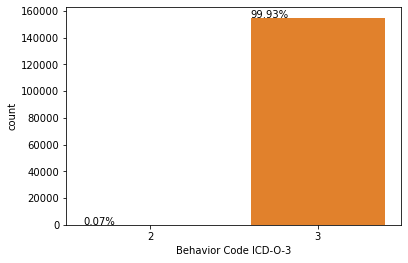

In [40]:
cat_percent_plot('Behavior Code ICD-O-3', train)

In [41]:
for dataset in combine:
    dataset.drop(['Behavior Code ICD-O-3'], axis=1, inplace=True)

## Diagnostic Confirmation(癌症確診方式)
* 資料大多為1或2
* 將5~8併成一類，9用mode取代
* 欄位描述  
1-4: 經顯微鏡檢證實(1: 組織病理學確診；2: 細胞學確診)  
5-8: 未經顯微鏡檢證實  
9: 不清楚是否經顯微鏡檢證實

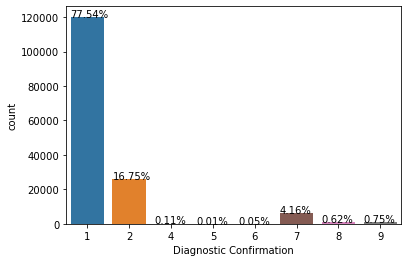

In [42]:
cat_percent_plot('Diagnostic Confirmation', train)

In [43]:
confirmation_mode = train['Diagnostic Confirmation'].mode()[0]
for dataset in combine:
    dataset.loc[dataset['Diagnostic Confirmation'].isin(range(5, 9)), 'Diagnostic Confirmation'] = 5
    dataset.loc[dataset['Diagnostic Confirmation'] == 9, 'Diagnostic Confirmation'] = confirmation_mode

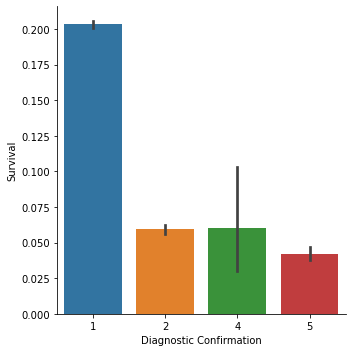

In [44]:
sns.catplot(x='Diagnostic Confirmation', y='Survival', data=train, kind='bar')

## CS Tumor Size(腫瘤大小)
* Code 991-995分別代表小於1-5公分，用各區間(1-10, 10-20, 20-30, 30-40, 40-50)的median取代  
* 25.6%為999(unknown)，以median取代(right skewed distribution)  
* 將單位由mm轉成cm

In [45]:
# Code 991-995 represent tumor size less than 1-5 mm respectively.
# Replace 991-995 with mean of each interval(1-10, 10-20, etc.)
tumor_size= {991: range(1, 10), 992: range(10, 20), 993: range(20, 30), 994: range(30, 40), 995: range(40, 50)}
for dataset in combine:
    for size in tumor_size.keys():
        median = dataset.loc[dataset['CS Tumor Size'].isin(tumor_size[size]),'CS Tumor Size'].median()
        median = int(round(median, 0))
        dataset.loc[dataset['CS Tumor Size'] == size, 'CS Tumor Size'] = median

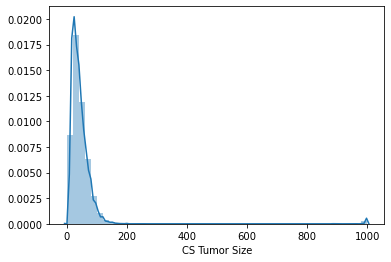

In [46]:
# Distribution of tumor size is right skewed.
# Replace 999(unknown) with median.
sns.distplot(train.loc[train['CS Tumor Size'] != 999, 'CS Tumor Size'], bins=50)
plt.show()

median = int(train.loc[train['CS Tumor Size'] != 999, 'CS Tumor Size'].median())
for dataset in combine:
    dataset.loc[dataset['CS Tumor Size'] == 999, 'CS Tumor Size'] = median

In [47]:
# Convert mm to cm.
for dataset in combine:
    dataset['CS Tumor Size'] = dataset['CS Tumor Size'] / 10

## Derived AJCC T/N/M/Stage Group
* These are ordinal features.
* Map code 88(Not applicable) to code -99
* 繪製各欄位的coutplot
    * T: 約35%的個案腫瘤不限大小，直接侵犯到縱膈腔、心臟、大血管、氣管、食道、喉返神經、脊椎體、氣管分岔部
    * N: 約38%的個案無區域淋巴結轉移
    * M: 約50%的個案無遠端轉移
    * Stage Group: 約42%的個案為第四期
* 繪製各欄位每個category的生存率
    * 四個欄位皆以code=88(Not applicable)生存率為最高
    * T: 基本上生存率隨著腫瘤侵犯的範圍擴大而下降
    * N: 生存率隨著淋巴結轉移的範圍擴大而下降
    * M: 無遠端轉移的生存率較有遠端轉移的高
    * Stage Group: 越後期生存率越低

欄位描述:
* TNM分期系統被用來評估癌症的預後
* 使用AJCC第6版分期法，以原發腫瘤(Primary Tumor, T)、淋巴結轉移(Regional Lymph Nodes, N)及遠端轉移(Distant Metastasis, M)為依據，來決定分期(Stage Group)

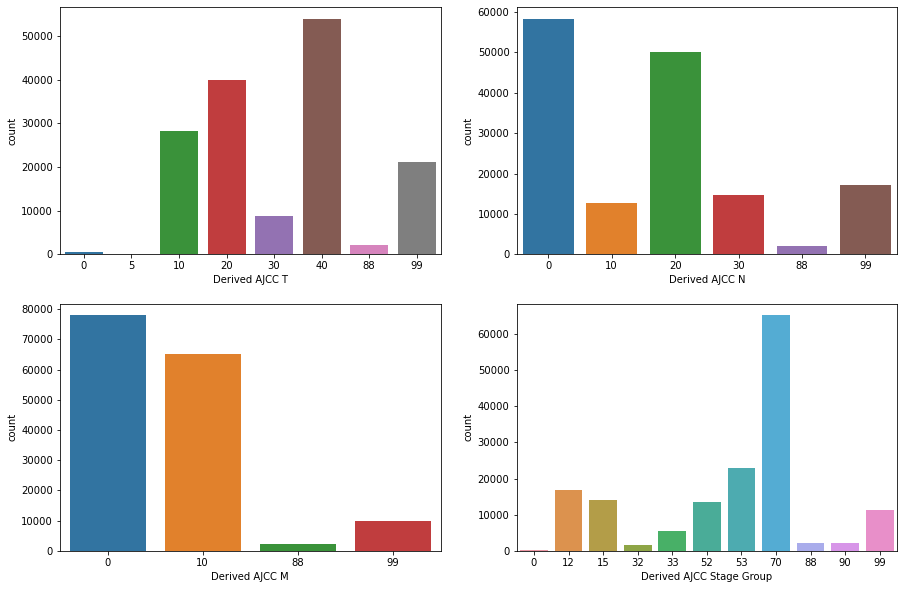

In [48]:
ajcc = ['Derived AJCC T', 'Derived AJCC N', 'Derived AJCC M', 'Derived AJCC Stage Group']
plt.figure(figsize=(15, 10))
for i, col in enumerate(ajcc):
    plt.subplot(2,2,i+1)
    sns.countplot(x=col, data=train)
plt.show()

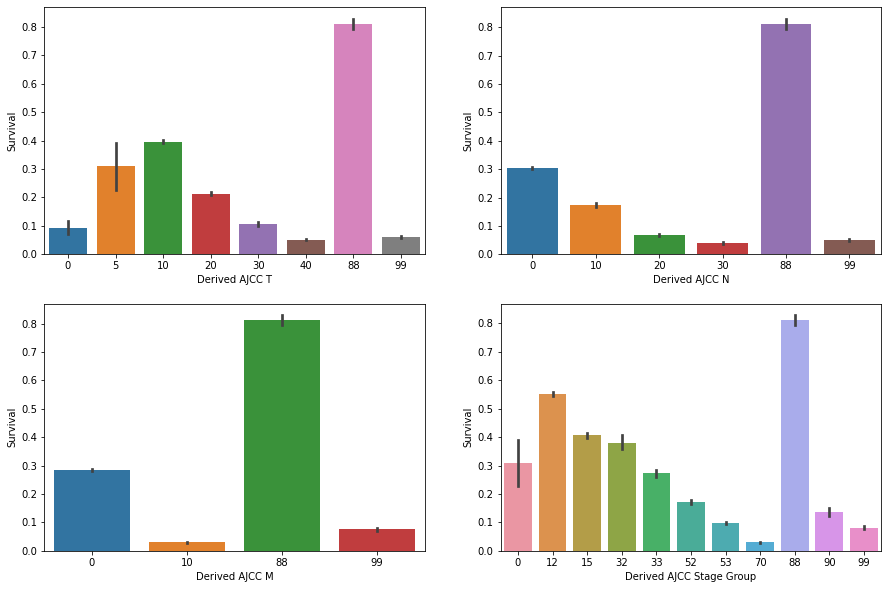

In [49]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(ajcc):
    plt.subplot(2,2,i+1)
    sns.barplot(x=col, y='Survival', data=train)
plt.show()

In [50]:
for dataset in combine:
    for col in ajcc:
        dataset.loc[dataset[col] == 88, col] = -99

## RX Summ—Surg Prim Site(原發部位手術方式)
* Nominal feature
* 73.75%的個案未進行原發部位手術(code = 0)
* code = 99(占0.8)為不清楚個案是否有接受手術治療，以mode(code = 0, 未進行原發部位手術)取代
* code = 90(占0.23%)為有進行手術但不清楚手術方式，以排除code = 0(未進行原發部位手術)後的mode取代
* 大部分的category資料量都占不到1%，依相關文件將手術方式合併在一起  
https://seer.cancer.gov/archive/manuals/2016/AppendixC/Surgery_Codes_Lung_2016.pdf
* 欄位描述  
    去除和/或破壞原發部位的組織，為初始檢查或第一療程的一部分


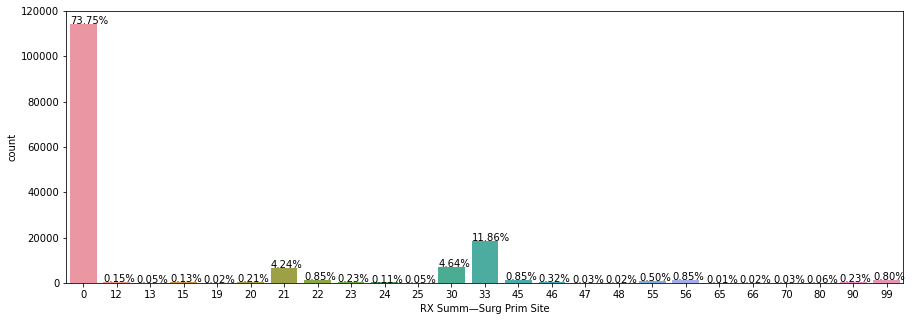

In [51]:
plt.figure(figsize=(15, 5))
cat_percent_plot('RX Summ—Surg Prim Site', train)

In [52]:
# Replace code 99 with mode.
# Replace code 90 with most frequect surgery type.
# Combine surgery types.
mode = train['RX Summ—Surg Prim Site'].mode()[0]
surg_mode = train.loc[train['RX Summ—Surg Prim Site'] != 0, 'RX Summ—Surg Prim Site'].mode()[0]
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['0','10-19','20-29','30-39', '40-49', '50-59', '60-69', '70', '80']
for dataset in combine:
    dataset.loc[dataset['RX Summ—Surg Prim Site'] == 99, 'RX Summ—Surg Prim Site'] = mode
    dataset.loc[dataset['RX Summ—Surg Prim Site'] == 90, 'RX Summ—Surg Prim Site'] = surg_mode
    dataset['RX Summ—Surg Prim Site'] = pd.cut(dataset['RX Summ—Surg Prim Site'], bins=bins, right=False, labels=labels)
    dataset['RX Summ—Surg Prim Site'] = dataset['RX Summ—Surg Prim Site'].astype('object')

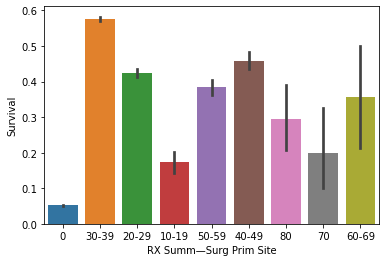

In [53]:
sns.barplot(x='RX Summ—Surg Prim Site', y='Survival', data=train)

## RX Summ—Scope Reg LN Sur (區域淋巴結手術範圍)
* Oridnal feature
* code = 9(Unknown)，以mode取代
* 72.39%未去除或抽吸區域淋巴結(或考慮區分為有去除/無去除?)

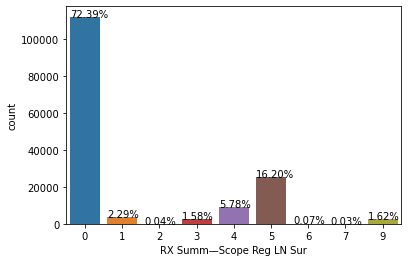

In [54]:
cat_percent_plot('RX Summ—Scope Reg LN Sur', train)

In [55]:
mode = train['RX Summ—Scope Reg LN Sur'].mode()[0]
for dataset in combine:
    dataset.loc[dataset['RX Summ—Scope Reg LN Sur'] == 9, 'RX Summ—Scope Reg LN Sur'] = mode

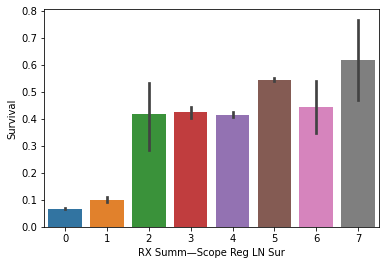

In [56]:
sns.barplot(x='RX Summ—Scope Reg LN Sur', y='Survival', data=train)

## Reason for no surgery (發部位未手術原因)
* Code 8 & Code 9為Unknown，以mode取代
* Code 2~7資料量少，合併成others

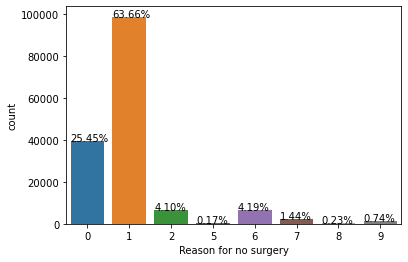

In [57]:
cat_percent_plot('Reason for no surgery', train)

In [58]:
mode = train['Reason for no surgery'].mode()[0]
for dataset in combine:
    dataset.loc[dataset['Reason for no surgery'].isin([8, 9]), 'Reason for no surgery'] = mode
    dataset.loc[dataset['Reason for no surgery'].isin(range(2, 8)), 'Reason for no surgery'] = 'others'

## Race recode (W, B, AI, API)種族
* code 9為Unknown，依mode取代
* 合併code 3與code 4，兩者資料量少

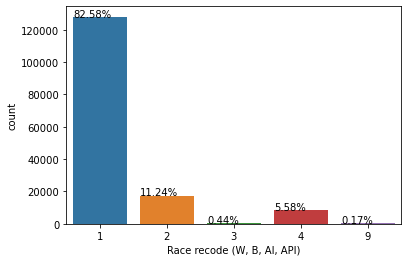

In [59]:
cat_percent_plot('Race recode (W, B, AI, API)', train)

In [60]:
mode = train['Race recode (W, B, AI, API)'].mode(0)[0]
for dataset in combine:
    dataset.loc[dataset['Race recode (W, B, AI, API)'] == 9, 'Race recode (W, B, AI, API)'] = mode
    dataset.loc[dataset['Race recode (W, B, AI, API)'].isin([3, 4]), 'Race recode (W, B, AI, API)'] = 'others'
    dataset['Race recode (W, B, AI, API)'] = dataset['Race recode (W, B, AI, API)'].map({1: 'White', 2: 'Black', 'others': 'others'})

## Grade (分級/分化)
* Ordinal feature  
* Unknown(code=9)占了48.97%，以(-99)取代
* 欄位描述:  
用來描述腫瘤與正常細胞的相似程度，分化愈好的(愈像正常組織)，級數愈低；分化愈差的，級數愈高。為影響預後與存活時間的因子。  
    * Code 1-4分別代表第一級-第四級
    * Code 9為Unknown

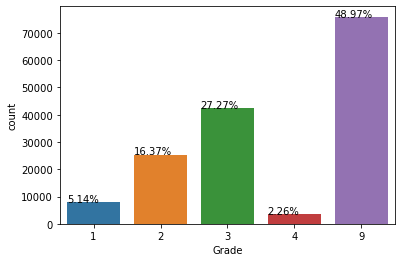

In [61]:
cat_percent_plot('Grade', train)

In [62]:
for dataset in combine:
    dataset.loc[dataset['Grade'] == 9, 'Grade'] = -99

## Encoding nominal features
將Nominal features做one-hot encoding
* Nominal features:  
Marital Status at DX  
Primary Site  
Laterality  
Histologic Type ICD-O-3  
Diagnostic Confirmation  
CS Site-Specific Factor 1  
RX Summ—Surg Prim Site  
Reason for no surgery  
Race recode (W, B, AI, API)  
Origin recode NHIA (Hispanic, NonHisp)  
* Ordinal features:  
Grade  
CS Extension  
CS Lymph Nodes  
CS Mets at Dx  
Derived AJCC T  
Derived AJCC N  
Derived AJCC M  
Derived AJCC Stage Group  
RX Summ—Scope Reg LN Sur  

In [63]:
ordinal = ['Grade', 'CS Extension', 'CS Lymph Nodes', 'CS Mets at Dx', 'Derived AJCC T',
           'Derived AJCC N', 'Derived AJCC M', 'Derived AJCC Stage Group', 'RX Summ—Scope Reg LN Sur']
nominal = ['Marital Status at DX', 'Primary Site', 'Laterality', 'Histologic Type ICD-O-3',
           'Diagnostic Confirmation', 'CS Site-Specific Factor 1', 'RX Summ—Surg Prim Site',
           'Reason for no surgery', 'Race recode (W, B, AI, API)', 'Origin recode NHIA (Hispanic, NonHisp)']

In [64]:
for dataset in combine:
    dataset['CS Site-Specific Factor 1'] = dataset['CS Site-Specific Factor 1'].astype(int)
    dataset[nominal] = dataset[nominal].astype(str)

In [65]:
onehotencoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
onehotencoder.fit(train[nominal])

for i, dataset in enumerate(combine):
    encoded = pd.DataFrame(onehotencoder.transform(dataset[nominal]), columns=onehotencoder.get_feature_names(nominal))
    combine[i] = pd.concat([dataset.drop(nominal, axis=1).reset_index(drop = True), encoded], axis=1)
train, test = combine

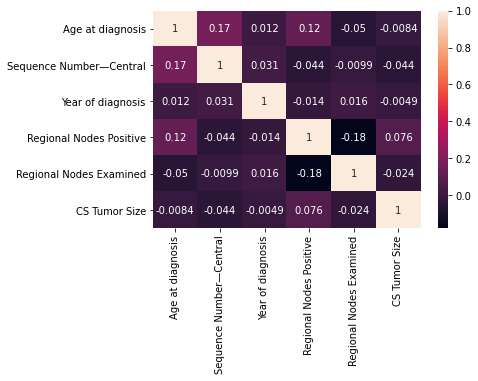

In [66]:
numerical_col.remove('Survival months')
sns.heatmap(train[numerical_col].corr(), annot=True)

## Feature Selection
* 使用Wrapper方法做feature selection
* 共挑出25個欄位

In [67]:
x_train, y_train = train.drop(['Survival'], axis=1), train['Survival']
x_test, y_test = test.drop(['Survival'], axis=1), test['Survival']

In [68]:
adaboost = AdaBoostClassifier(random_state = 0)
rfecv = RFECV(estimator=adaboost, step=1, cv=StratifiedKFold(5), scoring='roc_auc', verbose=0, n_jobs=-1)
rfecv.fit(x_train, y_train) 
print(f'Optimal number of features is {rfecv.n_features_}')
features = [f for f,s in zip(x_train.columns, rfecv.support_) if s]
print('The selected features are:')
print (features)

Optimal number of features is 25
The selected features are:
['Sex', 'Age at diagnosis', 'Year of diagnosis', 'Grade', 'Regional Nodes Positive', 'CS Tumor Size', 'CS Extension', 'CS Lymph Nodes', 'CS Mets at Dx', 'Derived AJCC T', 'Derived AJCC M', 'Derived AJCC Stage Group', 'First malignant primary indicator', 'Marital Status at DX_Married', 'Primary Site_C341', 'Histologic Type ICD-O-3_others', 'Diagnostic Confirmation_1', 'Diagnostic Confirmation_5', 'CS Site-Specific Factor 1_988', 'RX Summ—Surg Prim Site_0', 'RX Summ—Surg Prim Site_10-19', 'RX Summ—Surg Prim Site_20-29', 'Reason for no surgery_0', 'Race recode (W, B, AI, API)_Black', 'Race recode (W, B, AI, API)_others']


In [69]:
# data of selected features
x_train_fs = x_train[features]
x_test_fs = x_test[features]

## Baseline model

In [70]:
sme = SMOTEENN(random_state=0)
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0)
imba_pipeline = Pipeline([('sme', sme), ('adaboost', adaboost)])
scorings = ['accuracy', 'roc_auc']
scores = cross_validate(imba_pipeline, x_train_fs, y_train, cv=5, scoring=scorings)

print('-'*20 + 'Scores of training data' + '-'*20)
print('Accuracy of training data: ', scores['test_accuracy'].mean())
print('AUC of training data: ', scores['test_roc_auc'].mean())

--------------------Scores of training data--------------------
Accuracy of training data:  0.83500964006364
AUC of training data:  0.8918882469285718


## Hyperparameters tuning & Resampling

In [71]:
model_params = {
    'base_estimator': DecisionTreeClassifier(max_depth=1),
    'n_estimators': 50,
    'learning_rate': 1,
    'random_state': 0
}

In [72]:
sme = SMOTEENN(random_state=0)
adaboost = AdaBoostClassifier(**model_params)
imba_pipeline = Pipeline([('sme', sme), ('adaboost', adaboost)])

In [73]:
params1 = {'adaboost__base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=5), DecisionTreeClassifier(max_depth=10)]}
grid1 = GridSearchCV(imba_pipeline, param_grid=params1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid1.fit(x_train_fs, y_train)

print(grid1.best_params_)
print(grid1.best_score_)

{'adaboost__base_estimator': DecisionTreeClassifier(max_depth=1)}
0.8918882469285718


In [74]:
params2 = {'adaboost__base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                                        DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4)]}
grid2 = GridSearchCV(imba_pipeline, param_grid=params2, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid2.fit(x_train_fs, y_train)

print(grid2.best_params_)
print(grid2.best_score_)

{'adaboost__base_estimator': DecisionTreeClassifier(max_depth=2)}
0.896710175303447


In [75]:
model_params['base_estimator'] = DecisionTreeClassifier(max_depth=2)
adaboost = AdaBoostClassifier(**model_params)
imba_pipeline = Pipeline([('sme', sme), ('adaboost', adaboost)])

In [77]:
params3 = {'adaboost__n_estimators': [50, 100, 300, 500, 1000, 1500]}
grid3 = GridSearchCV(imba_pipeline, param_grid=params3, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid3.fit(x_train_fs, y_train)

print(grid3.best_params_)
print(grid3.best_score_)

{'adaboost__n_estimators': 100}
0.897096550327845


In [78]:
params4 = {'adaboost__n_estimators': [75, 100, 150, 200, 250]}
grid4 = GridSearchCV(imba_pipeline, param_grid=params4, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid4.fit(x_train_fs, y_train)

print(grid4.best_params_)
print(grid4.best_score_)

{'adaboost__n_estimators': 100}
0.897096550327845


In [82]:
model_params['n_estimators'] = 100
adaboost = AdaBoostClassifier(**model_params)
imba_pipeline = Pipeline([('sme', sme), ('adaboost', adaboost)])

In [84]:
params5 = {'adaboost__learning_rate': [0.001, 0.01, 0.1, 1]} 
grid5 = GridSearchCV(imba_pipeline, param_grid=params5, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid5.fit(x_train_fs, y_train)

print(grid5.best_params_)
print(grid5.best_score_)

{'adaboost__learning_rate': 1}
0.897096550327845


In [85]:
grid5.best_estimator_

Pipeline(steps=[('sme', SMOTEENN(random_state=0)),
                ('adaboost',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                    learning_rate=1, n_estimators=100,
                                    random_state=0))])

## Predict
* Accuracy=0.88
* AUC=0.9

In [109]:
adaboost = grid5.best_estimator_['adaboost']
scores = cross_validate(adaboost, x_train_fs, y_train, cv=5, scoring=scorings)
print('-'*20 + 'Scores of training data' + '-'*20)
print('Accuracy of training data: ', scores['test_accuracy'].mean())
print('AUC of training data: ', scores['test_roc_auc'].mean())

adaboost.fit(x_train_fs, y_train)
y_pred_prob = adaboost.predict_proba(x_test_fs)
y_pred = adaboost.predict(x_test_fs)
print('-'*20 + 'Scores of testing data' + '-'*20)
print("Accuracy of testing data: ", accuracy_score(y_test, y_pred))
print("AUC of testing data: ", roc_auc_score(y_test, y_pred_prob[:, 1]))
print('-'*60)

--------------------Scores of training data--------------------
Accuracy of training data:  0.882292591394034
AUC of training data:  0.9009539026542462
--------------------Scores of testing data--------------------
Accuracy of testing data:  0.8825079030558483
AUC of testing data:  0.9003956541615111
------------------------------------------------------------


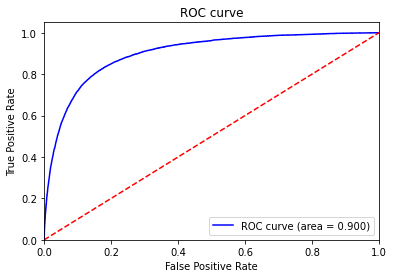

In [110]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b',label='ROC curve (area = %0.3f)' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature importances
TOP 5:  
CS Tumor Size(腫瘤大小)  
Age at diagnosis(診斷年齡)  
CS Extension(腫瘤擴散程度)  
CS Mets at Dx(診斷時遠端轉移)  
Derived AJCC Stage Group(腫瘤分期)  

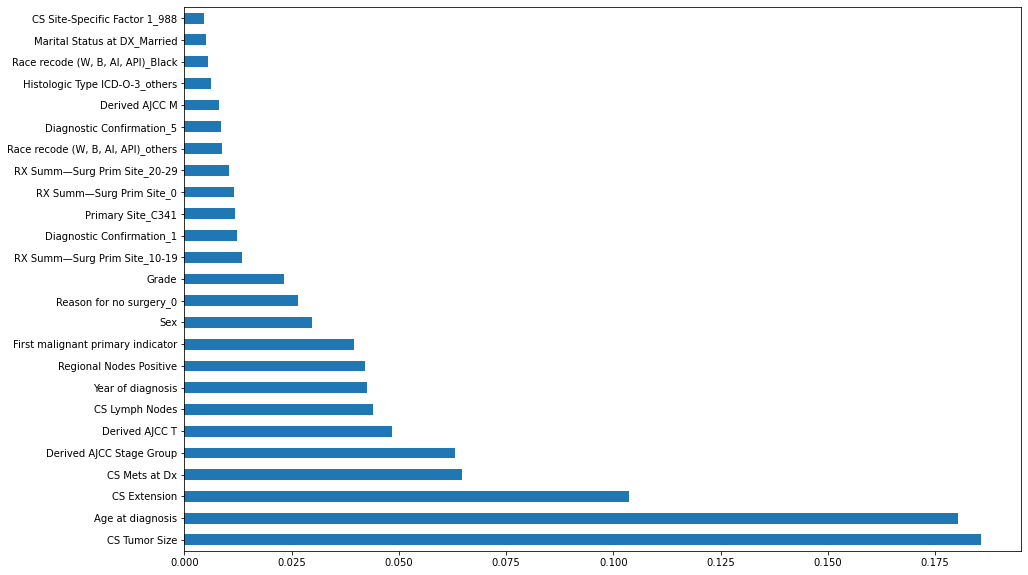

In [119]:
plt.figure(figsize=(15,10))
feat_importances = pd.Series(adaboost.feature_importances_, index=x_train_fs.columns).sort_values(ascending=False)
feat_importances.plot(kind='barh')
plt.show()

## **結論**
* 以Adaboost預測非小細胞肺癌患者第五年生存情形，其Accuracy=0.88，AUC=0.9。  
* 經feature selection選出來的features共25個，如下:  
    Sex, Age at diagnosis, Year of diagnosis, Grade, Regional Nodes Positive, CS Tumor Size, CS Extension, CS Lymph Nodes, CS Mets at Dx, Derived AJCC T, Derived AJCC M, Derived AJCC Stage Group, First malignant primary indicator, Marital Status at DX_Married, Primary Site_C341, Histologic Type ICD-O-3_others, Diagnostic Confirmation_1, Diagnostic Confirmation_5, CS Site-Specific Factor 1_988, RX Summ—Surg Prim Site_0, RX Summ—Surg Prim Site_10-19, RX Summ—Surg Prim Site_20-29, Reason for no surgery_0, Race recode (W, B, AI, API)_Black, Race recode (W, B, AI, API)_others
* 另從四份醫學相關文獻中找了分別找了四組非小細胞肺癌的預後因子，
    * 除了Derived AJCC N之外，其餘的特徵皆出現在上述25個機器學習所挑特徵中。
    * 機器學習所挑特徵亦挑出文獻中沒有出現的特徵:   
        Year of diagnosis, Regional Nodes Positive, CS Extension, CS Lymph Nodes, CS Mets at Dx, First malignant primary indicator, Primary Site, Diagnostic Confirmation, CS Site-Specific Factor 1, RX Summ—Surg Prim Site, Reason for no surgery